##Importing necessary libraries and functions

In [ ]:
#Installing Transformers library 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.3 MB/s eta 0:00:00


In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
import random
import torch
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForCausalLM, TrainingArguments, Trainer
from tqdm import tqdm, trange
import math

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
#Loading the final concatenated preprocessed Recipe dataset
df = pd.read_csv('/content/drive/MyDrive/685 Project/Final_dataset')

In [ ]:
#Dropping the title column
df.drop(['title'], axis=1, inplace=True)

In [ ]:
df.head()

,ingredients,instructions
0,"[brown sugar, milk, vanilla, nuts, butter, bit...","In a heavy 2-quart saucepan, mix brown sugar, ..."
1,"[chicken, chicken gravy, cream of mushroom sou...",Boil and debone chicken. Put bite size pieces ...
2,"[pineapple, condensed milk, lemons, pecans, gr...",Empty Cool Whip into a bowl. Drain juice from ...
3,"[dark sweet pitted cherries, ginger ale, flavo...","Drain cherries, measuring syrup. Cut cherries ..."
4,"[powdered sugar, butter, peanut butter, paraff...","Mix sugar, butter and peanut butter. Roll into..."


## Data Preparation

In [ ]:
# We load the GPT2 Fast Tokenizer
base_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

In [ ]:
# Checking the size of Tokenizer's vocabulary 
print('Words in vocabulary: ', base_tokenizer.vocab_size)

In [ ]:
from sklearn.model_selection import train_test_split

#Processing different columns into a single paragraph (column) - better for pretraining objective (next word prediction - causal language modeling) 
prepare_text = lambda x: ' '.join(["Ingredients:" , x['ingredients'], "Recipe:", x['instructions']])
df['Input'] = df.apply(prepare_text, axis=1)

# Split in train and test - 90% train and 10% train
df_train, df_val = train_test_split(df, train_size = 0.9, random_state = 77)

#Train and validation dataset sizes
print(f'There are {len(df_train)} recipes for training and {len(df_val)} for validation')

There are 579191 recipes for training and 64355 for validation


In [ ]:
# Reset the index of dataframes are split
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

In [ ]:
df_val.head()

,ingredients,instructions,Input
0,"[fresh strawberries, strawberry Jell-O, boilin...",Put strawberries in blender container; cover a...,"Ingredients: [fresh strawberries, strawberry J..."
1,['1 small butternut squash (about 1 1/2 pounds...,"1) Halve, seed and peel squash. Cut into bite-...",Ingredients: ['1 small butternut squash (about...
2,"[margarine, sugar, egg, milk, salt, baking pow...",Cream the margarine. Add sugar and beat until ...,"Ingredients: [margarine, sugar, egg, milk, sal..."
3,"[dinner rolls, brown sugar, regular butterscot...",Grease and flour Bundt cake pan. Place frozen ...,"Ingredients: [dinner rolls, brown sugar, regul..."
4,"[apple, lemon juice, trout]",Combine apple slices and lemon juice in medium...,"Ingredients: [apple, lemon juice, trout] Recip..."


In [ ]:
#Tokenizing the input
#Truncation is done if the length exceeds maximum length 
def preprocess_function(input, tokenizer = base_tokenizer):
    return base_tokenizer(input, add_special_tokens=True, truncation=True, max_length = 1024)['input_ids']

In [ ]:
#Modifying the recipe into a prompt based input for the baseline model 
def prompt_to_test(x):
  return ' '.join(["Generate a recipe using following", x])

In [ ]:
#Tokenizer do not have an explicit pad token, therefore setting pad token to eos token 
base_tokenizer.pad_token = base_tokenizer.eos_token

In [ ]:
#Baseline is not finetuned on the preprocessed dataset
#Testing for baseline is done on the same validation dataset used for the finetuned model
baseline_val = df_val['Input']
baseline_val = baseline_val.apply(prompt_to_test)

In [ ]:
#Applying the prompt preprocessing to the baseline validation dataset
baseline_val = baseline_val.apply(preprocess_function)

In [ ]:
#Tokenizing the train and validation dataset for the model
df_train= df_train['Input'].apply(preprocess_function)
df_val = df_val['Input'].apply(preprocess_function)

In [ ]:
# Can store the datasets and load later to avoid performing data split and tokenization redundantly 

# df_train.to_csv('/content/drive/MyDrive/685 Project/RG_train_dataset', index=False)
# df_val.to_csv('/content/drive/MyDrive/685 Project/RG_test_dataset', index = False)
# baseline_val.to_csv('/content/drive/MyDrive/685 Project/RG_baseline_test_dataset', index = False)

## Training the GPT2 Model

In [ ]:
# Checking the size of the model in bytes

# !pip install objsize
# import objsize
# objsize.get_deep_size(base_model)

In [ ]:
# Loading the tokenized dataset if stored earlier

# df_train = pd.read_csv('/content/drive/MyDrive/685 Project/RG_train_dataset') 
# df_val = pd.read_csv('/content/drive/MyDrive/685 Project/RG_test_dataset')

In [ ]:
# df_train = df_train['Input']
# df_val = df_val['Input']

In [ ]:
#Initializing baseline model
base_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

In [ ]:
#Checking different parameters in the model
base_model.num_parameters

<bound method ModuleUtilsMixin.num_parameters of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)>

In [ ]:
#Initializing the GPT2 Fast Tokenizer
base_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

In [ ]:
#Setting pad token same as eos token
base_tokenizer.pad_token = base_tokenizer.eos_token

#Initializing Data Collator that forms batches and sends the input in a proper language modeling format to the model for training and evaluation
data_collator = DataCollatorForLanguageModeling(
        tokenizer=base_tokenizer,
        mlm=False,
        return_tensors="pt"
    )

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
#Specifying path where running logs, checkpoints and final model parameters will be stored
model_path = '/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2_20'

#Specifying the Training arguments for the model training 
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir = True,  #If there is any content present in the output directory, overwrite it
    evaluation_strategy="no",     # Do not perform evaluation during the training
    gradient_accumulation_steps=8, # Accumulate the gradients for 8 steps, before performing the weight updates
    num_train_epochs=20,        # Number of training epochs
    weight_decay=0.01,          # Weight update decay after each epoch
    warmup_steps=1_000,         # Number of training steps, before a weight update is performed
    lr_scheduler_type="cosine", 
    learning_rate=5e-4,         # Initial learning rate value
    save_steps=5_000,           # After how many training steps, should the model be checkpointed 
    fp16=True                   # Limit the precision of the weights to 16 floating points only
)

In [ ]:
trainer = Trainer(
    model=base_model,                         # the instantiated  Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,        #data collator 
    train_dataset=df_train,         # training dataset
    eval_dataset=df_val            # evaluation dataset
)

In [ ]:
#Model training
trainer.train()  

In [ ]:
#Saving model and the tokenizer
trainer.save_model()
base_tokenizer.save_pretrained(model_path)

## Inference (PERPLEXITY)

In [ ]:
import math

#Perplexity of the model is evaluated on the validation dataset 
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

##Testing Baseline DistilGPT2 (PERPLEXITY)

In [ ]:
#Initializing the baseline tokenizer
baseline_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

In [ ]:
#Setting the pad token to eos token
baseline_tokenizer.pad_token = baseline_tokenizer.eos_token

In [ ]:
#Initializing the baseline model (Non fine tuned DistilGPT2)
baseline_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

In [ ]:
#Creating a text generation pipeline to see how the baseline model performs on the task of recipe generation
from transformers import pipeline
baseline_generator = pipeline('text-generation', model=baseline_model, tokenizer = baseline_tokenizer)
input = "Generate a recipe using following Ingredients: [strawberry, cheese, milk, bread] Recipe:"
#Generating the results for the baseline model 
baseline_generator(input, max_length=150)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Generate a recipe using following Ingredients: [strawberry, cheese, milk, bread] Recipe: [Strawberry, cheese, graham crackers, Regardless (and all) of the ingredients listed above for "Seeding."\n\n\nA few ways to make it this way:\n1) Place a bowl of water between the bottom of the bowl and stir thoroughly. Place the bowl of water so that the water between the bottom of the bowl and stir thoroughly. Bring to a boil, and leave some water in place of the mixture so that the mixture is dry: If you do not like the texture of the mixture, combine the milk before cooking.\n2) Remove the bowl of water, and let it cool,'}]

In [ ]:
#If saved the dataset earlier, then can load it 
# baseline_val = pd.read_csv('/content/drive/MyDrive/685 Project/RG_baseline_test_dataset')

In [ ]:
# baseline_val = baseline_val['Input']

In [ ]:
baseline_val.head()

In [ ]:
# Creating the DataCollator for the evaluation dataset of the baseline model
baseline_data_collator = DataCollatorForLanguageModeling(
        tokenizer=baseline_tokenizer,
        mlm=False,
        return_tensors="pt"
    )

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
model_path = './baseline_model_RG'

#Specifying the training arguments - Although we are not performing training, but Trainer method requires this argument 
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir = True,
    gradient_accumulation_steps=8,
    num_train_epochs=0,   #Set the training epochs to 0, as we will not be doing any sort of training 
    weight_decay=0.01,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True
)

In [ ]:
trainer = Trainer(
    model=baseline_model,                         # the instantiated  Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=baseline_data_collator,
    eval_dataset=baseline_val          # evaluation dataset
)

In [ ]:
#Evaluating the baseline model using evaluation dataset on Perplexity  
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 28.58


##BLEU Score Evaluation

In [ ]:
#Installing the evaluate library for BLEU score evaluation 
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from evaluate import load
#Loading the BLEU score metric
bleu = load("bleu")

# predictions = ["hello there general kenobi", "foo bar foobar"]
# references = ["hello there general kenobi","foo bar foobar"]
# results = bleu.compute(predictions=predictions, references=references)

In [ ]:
# print(results)

{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.1666666666666667, 'translation_length': 7, 'reference_length': 6}


In [ ]:
#Function to separate the ingredients from the recipe 
def input_to_model(x):
  input = ' '.join(x.split()[:x.split().index('Recipe:')+1])
  return input

In [ ]:
baseline_val.head()

0    Generate a recipe using following Ingredients:...
1    Generate a recipe using following Ingredients:...
2    Generate a recipe using following Ingredients:...
3    Generate a recipe using following Ingredients:...
4    Generate a recipe using following Ingredients:...
Name: Input, dtype: object

In [ ]:
df_val.head()

,ingredients,instructions,Input
0,"[fresh strawberries, strawberry Jell-O, boilin...",Put strawberries in blender container; cover a...,"Ingredients: [fresh strawberries, strawberry J..."
1,['1 small butternut squash (about 1 1/2 pounds...,"1) Halve, seed and peel squash. Cut into bite-...",Ingredients: ['1 small butternut squash (about...
2,"[margarine, sugar, egg, milk, salt, baking pow...",Cream the margarine. Add sugar and beat until ...,"Ingredients: [margarine, sugar, egg, milk, sal..."
3,"[dinner rolls, brown sugar, regular butterscot...",Grease and flour Bundt cake pan. Place frozen ...,"Ingredients: [dinner rolls, brown sugar, regul..."
4,"[apple, lemon juice, trout]",Combine apple slices and lemon juice in medium...,"Ingredients: [apple, lemon juice, trout] Recip..."


In [ ]:
#Selecting 5000 validation samples to be evaluated using BLEU score 
num_of_samples = 5000
df_val = df_val[:num_of_samples]
baseline_val = baseline_val[:num_of_samples]

In [ ]:
#Creating dataframes for the FT model and baseline model to store the Reference and the Input to the models
test_baseline_val = pd.DataFrame(columns = ['Input','Reference'])
test_base_val = pd.DataFrame(columns = ['Input','Reference'])

In [ ]:
test_base_val['Reference'] = df_val['Input']
test_baseline_val['Reference'] = baseline_val
test_base_val['Input'] = df_val['Input'].apply(input_to_model)
test_baseline_val['Input'] = baseline_val.apply(input_to_model)

In [ ]:
#Load the models and tokenizers

baseline_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
baseline_tokenizer = AutoTokenizer.from_pretrained('distilgpt2') 

base_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2_20")
baseline_tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2Tokenizer') 

In [ ]:
from transformers import pipeline
#creating pipelines for FT model and baseline model
baseline_generator = pipeline('text-generation', model=baseline_model, tokenizer = baseline_tokenizer)
base_generator = pipeline('text-generation', model=base_model, tokenizer = base_tokenizer)

In [ ]:
test_baseline_val.head()

,Input,Reference
0,Generate a recipe using following Ingredients:...,Generate a recipe using following Ingredients:...
1,Generate a recipe using following Ingredients:...,Generate a recipe using following Ingredients:...
2,Generate a recipe using following Ingredients:...,Generate a recipe using following Ingredients:...
3,Generate a recipe using following Ingredients:...,Generate a recipe using following Ingredients:...
4,Generate a recipe using following Ingredients:...,Generate a recipe using following Ingredients:...


In [ ]:
num_beams = 1 
top_p = 1.0
do_sample = False

#Change num_beams to more than 1, to get a beam search decoding
#If do_sample is true, then ancestral sampling is performed
#Include top_p in ancestral to get Nucleus sampling

In [ ]:
#Greedy, Ancestral and Nucleus
decoding_strats = [[1,1.0, False],[1,1.0, True],[1,0.9, True]]

In [ ]:
#For each input, model performs recipe generation, then the prediction and the reference are stored for later use in BLEU score evaluation

#BLEU score eval of FT model
results = []
predictions = []
references = []
for x in decoding_strats:
  num_beams, top_p, do_sample = x
  for idx in test_base_val.iterrows():
    references.append(test_base_val['Reference'].iloc[idx])
    predictions.append(base_generator(str(test_base_val['Input'].iloc[idx]), num_beams = num_beams, top_p = top_p, do_sample = do_sample, max_length = 150)[0]['generated_text'])
  base_results = bleu.compute(predictions=predictions, references=references)
  results.append(base_results)
print(results)

In [ ]:
#BLEU score eval of baseline model
results = []
predictions = []
references = []
for x in decoding_strats:
  num_beams, top_p, do_sample = x
  for idx, row in test_baseline_val.iterrows():
    references.append(test_baseline_val['Reference'].iloc[idx])
    predictions.append(baseline_generator(str(test_baseline_val['Input'].iloc[idx]), num_beams = num_beams, top_p = top_p, do_sample = do_sample, max_length = 150)[0]['generated_text'])
  baseline_results = bleu.compute(predictions=predictions, references=references)
  results.append(baseline_results)
print(results)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

[{'bleu': 0.3061613521424476, 'precisions': [0.3739198743126473, 0.30324623911322246, 0.2841181165203512, 0.2727272727272727], 'brevity_penalty': 1.0, 'length_ratio': 1.041734860883797, 'translation_length': 1273, 'reference_length': 1222}, {'bleu': 0.30453436032452413, 'precisions': [0.3788476716653512, 0.29912490055688146, 0.2806736166800321, 0.2704122877930477], 'brevity_penalty': 1.0, 'length_ratio': 1.0368248772504092, 'translation_length': 2534, 'reference_length': 2444}, {'bleu': 0.3067048763117223, 'precisions': [0.38295064660860384, 0.300877893056664, 0.2823813354786806, 0.2719653960529873], 'brevity_penalty': 1.0, 'length_ratio': 1.0335515548281506, 'translation_length': 3789, 'reference_length': 3666}]


##Generations by the Model 

Here you can test the model on different ingredients as input and see what recipe it generates. Can see affect by try different decoding strategies and changing the maximum length

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
base_model = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2_20')
base_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2Tokenizer/")

In [ ]:
from transformers import pipeline

input = "Ingredients:  [rice, egg, chicken, shrimp, soy sauce, sesame oil, salt, pepper, green onion] Recipe:"
generator = pipeline("text-generation", model=base_model, tokenizer = base_tokenizer)
generator(input, max_length=150)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Ingredients:  [rice, egg, chicken, shrimp, soy sauce, sesame oil, salt, pepper, green onion] Recipe: Cook rice and set aside.  In a large nonstick frying pan, add olive oil and heat until almost smoking. Add chicken/seitan and cook covered for 10 minutes. Add shrimp and cook for 2-3 minutes. Add egg, cook until egg is cooked (scrambled). Add rice and stir up; add soy sauce and seasonings.  Garnish with chopped scallions and/or crushed red pepper. Serve hot. Enjoy.  Makes 4-6 servings as a main dish. Cooking time is 15-20 minutes.  Enjoy.  Serves 2.5. Per'}]

##Plotting of loss curve

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Loading the trainer_state json file, which consists of the losses at different steps/epochs
df = pd.read_json('/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2_20/trainer_state.json')

In [ ]:
df.head()

,best_metric,best_model_checkpoint,epoch,global_step,is_hyper_param_search,is_local_process_zero,is_world_process_zero,log_history,max_steps,num_train_epochs,total_flos,trial_name,trial_params
0,NaN,NaN,19.890841,180000,False,True,True,"{'epoch': 0.06, 'learning_rate': 0.00025, 'los...",180980,20,616695923127656448,NaN,NaN
1,NaN,NaN,19.890841,180000,False,True,True,"{'epoch': 0.11, 'learning_rate': 0.0005, 'loss...",180980,20,616695923127656448,NaN,NaN
2,NaN,NaN,19.890841,180000,False,True,True,"{'epoch': 0.17, 'learning_rate': 0.00049999047...",180980,20,616695923127656448,NaN,NaN
3,NaN,NaN,19.890841,180000,False,True,True,"{'epoch': 0.22, 'learning_rate': 0.00049996191...",180980,20,616695923127656448,NaN,NaN
4,NaN,NaN,19.890841,180000,False,True,True,"{'epoch': 0.28, 'learning_rate': 0.00049991431...",180980,20,616695923127656448,NaN,NaN


In [ ]:
#Abstraction of the loss and epochs from the log history 
def get_epoch(x):
  return x['epoch']

def get_loss(x):
  return x['loss']

In [ ]:
#Organize in a way to extract losses and steps
df['epoch_number'] = df['log_history'].apply(get_epoch)
df ['loss'] = df['log_history'].apply(get_loss)

Text(0.5, 1.0, 'Training curve DistilGPT2')

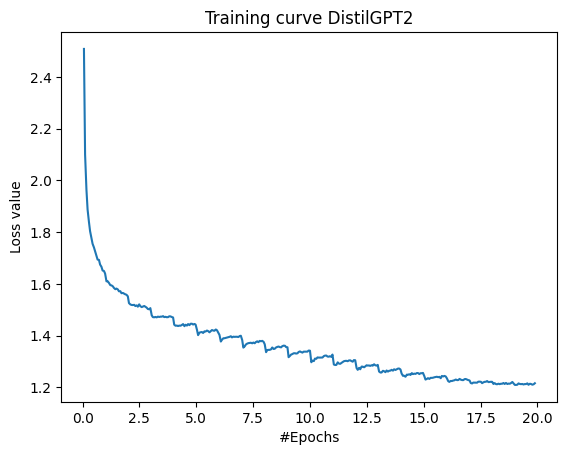

In [ ]:
#Plotting of the training loss curve for the FT Model 
plt.plot(df['epoch_number'].values, df['loss'].values) 
plt.xlabel('#Epochs')
plt.ylabel('Loss value')
plt.title('Training curve DistilGPT2')

In [ ]:
training_args = torch.load('/content/drive/MyDrive/685 Project/training_args.bin')

In [ ]:
#Training arguments used in the training process of the FT model 
print(training_args)

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=8,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=cuda_amp,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ig

##Adversarial Input Testing (Error Analysis)

There are several input cases, where the baseline model fails to follow the pattern it is supposed to, in many cases these are also called Adversarial Inputs to the model. In our experimentation we found four such failure cases of the model: \\

1) Ingredients to the model are some non-edible products \\
2) The number of ingredients are too less to create a recipe \\
3) Too many ingredients sepcified that the model is not able to utilize them all \\
4) Removal of the phrase 'Recipe:' from the input - model adds new ingredients 

In [ ]:
baseline_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

In [ ]:
baseline_tokenizer.pad_token = baseline_tokenizer.eos_token

In [ ]:
baseline_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

In [ ]:
from transformers import pipeline
baseline_generator = pipeline('text-generation', model=baseline_model, tokenizer = baseline_tokenizer)

In [ ]:
# Non sensical inputs
input = "Generate a recipe using following Ingredients: [strawberry, car, plastic, tire] Recipe:"
baseline_generator(input, max_length=150)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Generate a recipe using following Ingredients: [strawberry, car, plastic, tire] Recipe: [recipe, sour cream, pumpkin juice, ice cream, pumpkin jam, lime (not added), pumpkin pie\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nTo order this recipe, you can either use a recipe from this cookbook or create a separate page to add the recipe to the page. For example, my recipe for dressing ice cream, frozen pumpkin pie and pineapple pie is the link for this recipe.\nThis recipe can either be used by your own kitchen for your own baking and pie recipes, or by a kitchen for your own baked goods for your own kitchen, or by someone'}]

In [ ]:
#Very few inputs
input = "Generate a recipe using following Ingredients: [strawberry] Recipe:"
baseline_generator(input, max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Generate a recipe using following Ingredients: [strawberry] Recipe: [fresh green apples] Recipe: [chocolate] Recipe: [sauce] Recipe: Recipe: [sauce] Recipe: [sauce] Recipe: [sauce] Recipe: [sauce] Recipe: [sauce] Nutrition Facts Nutritional Fat: 10g / grams Calories from Fat - Total Fat 1g / grams Fiber - Fat 6g / grams Fat - Total Fat 1g / grams Fiber - Fat 9g / grams Fiber - Fat 6g / grams Fat - Total Fat 1g / grams Fiber - Fat 5g / grams Fiber - Total Fat 1g / grams Fiber - Fat 6g / g Fiber'}]

In [ ]:
#Large number of inputs
input = "Generate a recipe using following Ingredients: [1 tbsp white vinegar, 6 Coles Australian Free Range Eggs, 500g fresh fettuccine or pappardelle,  6 pancetta slices, 2 Coles Australian Free Range Egg yolks, 1/2 cup (125ml) thickened cream, 1/2 cup (40g) finely grated parmesan, 120g pkt Coles Australian Baby Spinach] Recipe:"
baseline_generator(input, max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Generate a recipe using following Ingredients: [1 tbsp white vinegar, 6 Coles Australian Free Range Eggs, 500g fresh fettuccine or pappardelle,  6 pancetta slices, 2 Coles Australian Free Range Egg yolks, 1/2 cup (125ml) thickened cream, 1/2 cup (40g) finely grated parmesan, 120g pkt Coles Australian Baby Spinach] Recipe: [2] Prep Time 10 minutes Servings - 3 2 - 4 Calories from Fat - 30 kcal Author : Marcel Gersberg\n\n\n\n\n\n\n\n\n\n\n- Foul of the recipe\n\n\n\n\n\nHow many times do I have to use'}]

In [ ]:
# Exclusion of Recipe
input = "Generate a recipe using following Ingredients: [strawberry, cheese, milk, bread]"
baseline_generator(input, max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Generate a recipe using following Ingredients: [strawberry, cheese, milk, bread] 1 cup of vanilla extract\n1 tablespoon of ciander / vanilla extract Instructions Preheat the oven to 300-200 F. In a 350F oven, bring the milk, milk, and vanilla extract into a bowl. Slowly whisk together the spinach, mozzarella, oregano, and bay leaves or chopped ginger. Add the green juice and the remaining coconut milk, then stir to combine the spinach with the milk and juice. Remove from the oven and let cool for 40-45 minutes.\nPlace a tray on a baking sheet and place it in an oven until golden brown and completely golden brown. The topping will look nice on the surface'}]

In [ ]:
base_tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2Tokenizer')

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2_20')

In [ ]:
base_generator = pipeline('text-generation', model=base_model, tokenizer = base_tokenizer)

In [ ]:
# Non sensical inputs
input = "Generate a recipe using following Ingredients: [strawberry, car, plastic, tire] Recipe:"
base_generator(input, max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Generate a recipe using following Ingredients: [strawberry, car, plastic, tire] Recipe: Combine all ingredients in a large punch bowl and punch bowl. If you have trouble getting punch right down and you need something to help you have to do with. If you don't have Aguher, you might want to add sugar or sugar. Pour punch over crushed ice into a punch bowl and enjoy punch. I add an extra splash of lime juice to the punch bowl. Serves 50. This can easily be halved and put in a punch bowl. Can be made in large quantities and frzn. Toss lightly but do not make too thick. Serves 60. Can be doubled. Enjoy. Serves 100. Food exchange."}]

In [ ]:
#Very few inputs
input = "Generate a recipe using following Ingredients: [strawberry] Recipe:"
base_generator(input, max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Generate a recipe using following Ingredients: [strawberry] Recipe: Combine ingredients in a bowl and let stand at room temperature for 24 hours.  Notes: Substitute orange juice for white grape juice with orange juice. 1 1/2 jasmine tea bag, loosely packed. Pour a tsp or so into each cup of a teacup and fill with tequila. Serve chilled with or without a garnish of fresh fruit and sugar. Yield: 2 1/2 cups or 32 servings (approx. 0 cup per serving).  Read More http://www.ethanks-basting.com/recipe/recipe/ugget-cups.html?oc=linkback.AVier-v favoring'}]

In [ ]:
#Large number of inputs
input = "Generate a recipe using following Ingredients: [1 tbsp white vinegar, 6 Coles Australian Free Range Eggs, 500g fresh fettuccine or pappardelle,  6 pancetta slices, 2 Coles Australian Free Range Egg yolks, 1/2 cup (125ml) thickened cream, 1/2 cup (40g) finely grated parmesan, 120g pkt Coles Australian Baby Spinach] Recipe:"
base_generator(input, max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Generate a recipe using following Ingredients: [1 tbsp white vinegar, 6 Coles Australian Free Range Eggs, 500g fresh fettuccine or pappardelle,  6 pancetta slices, 2 Coles Australian Free Range Egg yolks, 1/2 cup (125ml) thickened cream, 1/2 cup (40g) finely grated parmesan, 120g pkt Coles Australian Baby Spinach] Recipe: Bring the vinegar to the boil in a small saucepan, remove from the heat and cool to room temperature. Cook the pasta in a large pan of salted boiling water according to the packet directions. Add 3 tbsp (45ml) of the cooked pasta into the pan, and cook for'}]

In [ ]:
# Exclusion of Recipe
input = "Generate a recipe using following Ingredients: [strawberry, cheese, milk, bread]"
base_generator(input, max_length=150)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Generate a recipe using following Ingredients: [strawberry, cheese, milk, bread] Recipe: Whiz everything together in a blender until well blended and it becomes a thick spread.  Make sure you mix all the ingredients in a blender as this makes a smooth spread.  Spread that mixture on to the bread.  Place under the broiler about 4 minutes, or until the cheese browns and bubbles.  Serve.  Note: you may be able to slice these bread into about 10 pieces and spread them out a bit so they won't dry out. Also, the spread makes a nice finishing touch if you don't go big around with a spoon. Enjoy. Yum! :)!!!!! http://www.therealb"}]

##Sampling generations from the model for TST

In this section, we are taking 200 recipes that will be generated (by FT model) using inputs taken from the validation set. These recipes will be later used in the Text Style Transfer notebook. 

In [ ]:
# Extraction of the Ingredients from the entire input 
def input_to_model(x):
  input = ' '.join(str(x).split()[:str(x).split().index('Recipe:')+1])
  return input

In [ ]:
#Taking only 200 examples from the validation dataset 
df_val = df_val[:200]
df_val['M_Input'] = df_val['Input'].apply(input_to_model)

In [ ]:
df_val.head()

,ingredients,instructions,Input,M_Input
0,"[fresh strawberries, strawberry Jell-O, boilin...",Put strawberries in blender container; cover a...,"Ingredients: [fresh strawberries, strawberry J...","Ingredients: [fresh strawberries, strawberry J..."
1,['1 small butternut squash (about 1 1/2 pounds...,"1) Halve, seed and peel squash. Cut into bite-...",Ingredients: ['1 small butternut squash (about...,Ingredients: ['1 small butternut squash (about...
2,"[margarine, sugar, egg, milk, salt, baking pow...",Cream the margarine. Add sugar and beat until ...,"Ingredients: [margarine, sugar, egg, milk, sal...","Ingredients: [margarine, sugar, egg, milk, sal..."
3,"[dinner rolls, brown sugar, regular butterscot...",Grease and flour Bundt cake pan. Place frozen ...,"Ingredients: [dinner rolls, brown sugar, regul...","Ingredients: [dinner rolls, brown sugar, regul..."
4,"[apple, lemon juice, trout]",Combine apple slices and lemon juice in medium...,"Ingredients: [apple, lemon juice, trout] Recip...","Ingredients: [apple, lemon juice, trout] Recipe:"


In [ ]:
from transformers import pipeline
#Generating recipes and storing them in a dataframe
generations = []
base_model = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2_20')
base_tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/685 Project/RG_Model/DistilGPT2Tokenizer') 
base_tokenizer.pad_token = base_tokenizer.eos_token
base_generator = pipeline('text-generation', model=base_model, tokenizer = base_tokenizer)
for idx, row in df_val.iterrows():
  input = str(df_val['M_Input'].iloc[idx])
  generations.append(base_generator(input, max_length=150)[0]['generated_text'])
df_val['M_Output'] = generations

In [ ]:
df_val = df_val[['M_Input','M_Output']]

In [ ]:
#Saving the dataframe for future use
df_val.to_csv('/content/drive/MyDrive/685 Project/TST_Recipe_Inputs_and_Generations', index=False)